## Section 3: Hierarchal modeling
A key strength of Bayesian modeling is the easy and flexibility with which one can implement a hierarchical model. This section will implement and compare a pooled & partially pooled model.

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns

from IPython.display import Image
from sklearn import preprocessing


%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

### Model Pooling
Let's explore a different way of modeling the response time for my hangout conversations. My intuition would suggest that my tendency to reply quickly to a chat depends on who I'm talking to. I might be more likely to respond quickly to my girlfriend than to a distant friend. As such, I could decide to model each conversation independently, estimating parameters $\mu_i$ and $\alpha_i$ for each conversation $i$.

One consideration we must make, is that some conversations have very few messages compared to others. As such, our estimates of response time for conversations with few messages will have a higher degree of uncertainty than conversations with a large number of messages. The below plot illustrates the discrepancy in sample size per conversation.

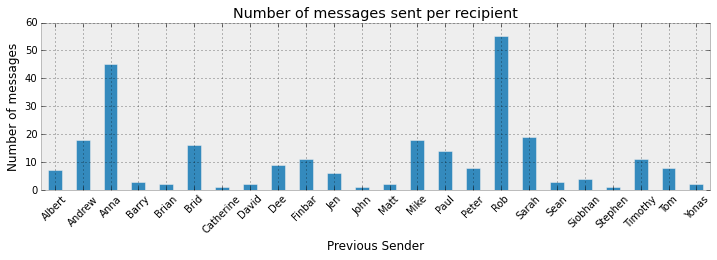

In [2]:
ax = messages.groupby('prev_sender')['conversation_id'].size().plot(
    kind='bar', figsize=(12,3), title='Number of messages sent per recipient', color=colors[0])
_ = ax.set_xlabel('Previous Sender')
_ = ax.set_ylabel('Number of messages')
_ = plt.xticks(rotation=45)

For each message j and each conversation i, we represent the model as:

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$
$$\mu_i = Uniform(0, 100)$$
$$\alpha_i = Uniform(0, 100)$$

In [3]:
indiv_traces = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(messages['prev_sender'])
participants = le.classes_
n_participants = len(participants)

for p in participants:
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)
        
        data = messages[messages['prev_sender']==p]['time_delay_seconds'].values
        y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=data)

        y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(20000, step, start=start, progressbar=True)
        
        indiv_traces[p] = trace

Applied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 9.7 secApplied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 12.4 secApplied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 12.0 secApplied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 12.0 secApplied interval-transform to alpha and added transfo

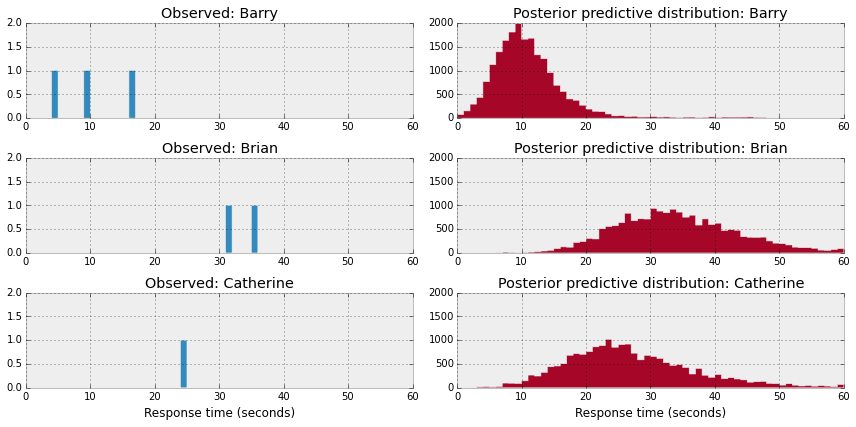

In [4]:
fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 2
y_right_max = 2000
x_lim = 60
ix = [3,4,6]

for i, j, p in zip([0,1,2], [0,2,4], participants[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(messages[messages['prev_sender']==p]['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,5], participants[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('Response time (seconds)')
axs[5].set_xlabel('Response time (seconds)')

plt.tight_layout()

The above plots show the observed data (left) and the posterior predictive distribution (right) for 3 example conversations we modeled. As you can see, the posterior predictive distribution can vary considerably across conversations. This could accurately reflect the characteristics of the conversation or it could be inaccurate due to small sample size.

If we combine the posterior predictive distributions across these models, we would expect this to resemble the distribution of the overall dataset observed. Let's perform the posterior predictive check.

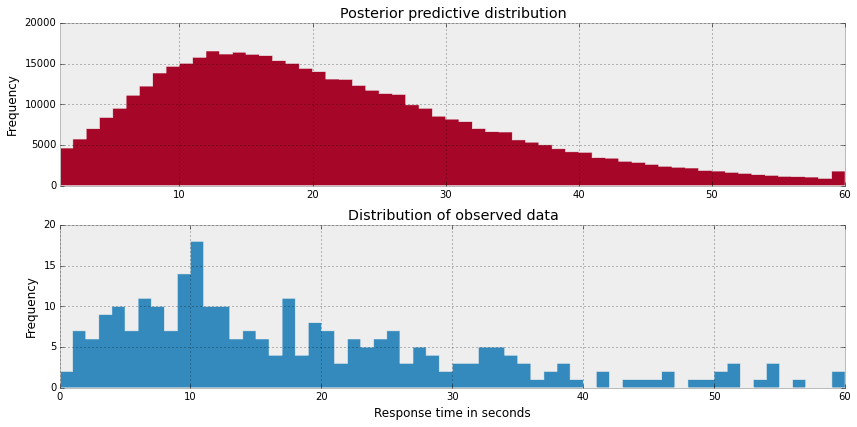

In [5]:
combined_y_pred = np.concatenate([v.get_values('y_pred') for k, v in indiv_traces.items()])

x_lim = 60
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(combined_y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylim(0, 20000)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylim(0, 20)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

Yes, the posterior predictive distribution resembles the distribution of the observed data. However, I'm concerned that some of the conversations have very little data and hence the estimates are likely to have high variance. One way to mitigate this risk to to share information across conversations - but still estimate $\mu_i$ for each conversation. We call this partial pooling.

### Partial pooling
Just like in the pooled model, a partially pooled model has paramater values estimated for each conversation i. However, parameters are connected together via hyperparameters. This reflects our belief that my `response_time`'s per conversation have similarities with one another via my own natural tendancy to respond quickly or slowly.

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$

Following on from the above example, we will estimate parameter values $(\mu_i)$ and $(\alpha_i)$ for a Poisson distribution. Rather than using a uniform prior, I will use a Gamma distribution for both $\mu$ and $\sigma$. This will enable me to introduce more prior knowledge into the model as I have certain expectations as to what vales $\mu$ and $\sigma$ will be.

First, let's have a look at the Gamma distribution. As you can see below, it is very flexible. 

Applied log-transform to gamma and added transformed gamma_log to model.
Applied log-transform to gamma and added transformed gamma_log to model.
Applied log-transform to gamma and added transformed gamma_log to model.


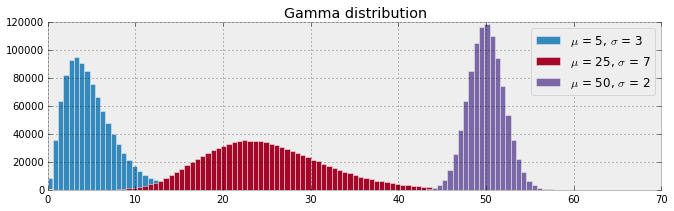

In [6]:
mu = [5,25,50]
sd = [3,7,2]

plt.figure(figsize=(11,3))
_ = plt.title('Gamma distribution')

with pm.Model() as model:
    for i, (j, k) in enumerate(zip(mu, sd)):
        samples = pm.Gamma('gamma', mu=j, sd=k).random(size=10**6)
        plt.hist(samples, bins=100, range=(0,60), color=colors[i], alpha=1)

_ = plt.legend(['$\mu$ = %s, $\sigma$ = %s' % (mu[a], sd[a]) for a in [0,1,2]])

The partially pooled model can be formally described by:

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$
$$\mu_i = Gamma(\mu_\mu, \sigma_\mu)$$
$$\alpha_i = Gamma(\mu_\alpha, \sigma_\alpha)$$
$$\mu_\mu = Uniform(0, 60)$$
$$\sigma_\mu = Uniform(0, 50)$$
$$\mu_\alpha = Uniform(0, 10)$$
$$\sigma_\alpha = Uniform(0, 50)$$

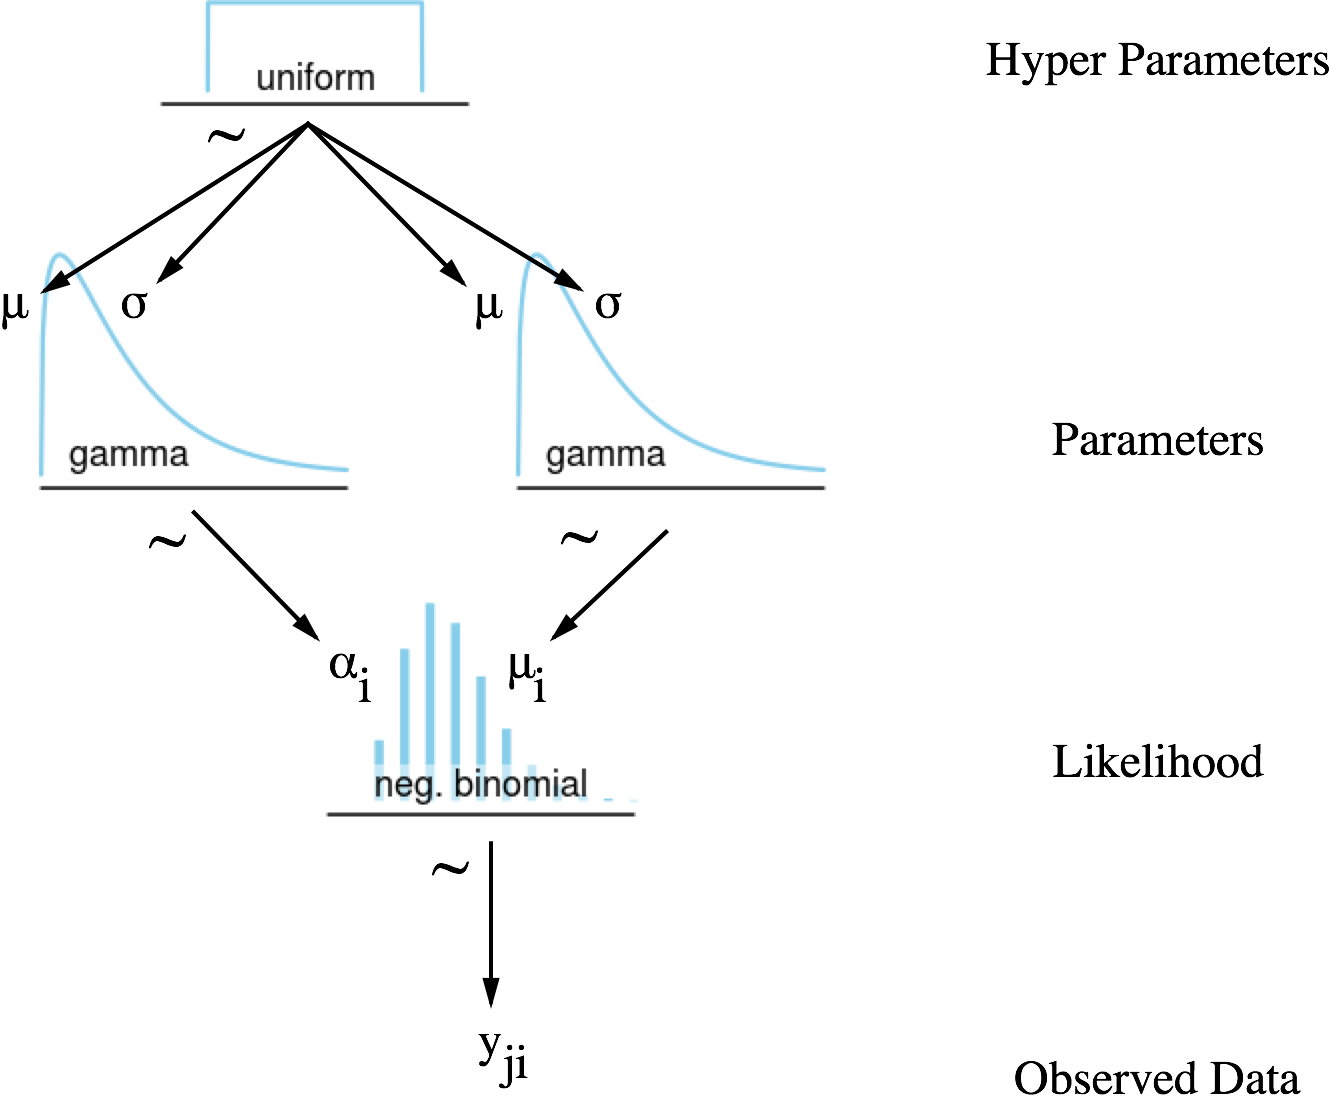

In [7]:
Image('graphics/dag neg poisson gamma hyper.png', width=420)

In [8]:
with pm.Model() as model:
    hyper_alpha_sd = pm.Uniform('hyper_alpha_sd', lower=0, upper=50)
    hyper_alpha_mu = pm.Uniform('hyper_alpha_mu', lower=0, upper=10)
    
    hyper_mu_sd = pm.Uniform('hyper_mu_sd', lower=0, upper=50)
    hyper_mu_mu = pm.Uniform('hyper_mu_mu', lower=0, upper=60)
    
    alpha = pm.Gamma('alpha', mu=hyper_alpha_mu, sd=hyper_alpha_sd, shape=n_participants)
    mu = pm.Gamma('mu', mu=hyper_mu_mu, sd=hyper_mu_sd, shape=n_participants)
    
    y_est = pm.NegativeBinomial('y_est', 
                                mu=mu[participants_idx], 
                                alpha=alpha[participants_idx], 
                                observed=messages['time_delay_seconds'].values)
    
    y_pred = pm.NegativeBinomial('y_pred', 
                                 mu=mu[participants_idx], 
                                 alpha=alpha[participants_idx],
                                 shape=messages['prev_sender'].shape)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    hierarchical_trace = pm.sample(200000, step, progressbar=True)

Applied interval-transform to hyper_alpha_sd and added transformed hyper_alpha_sd_interval to model.
Applied interval-transform to hyper_alpha_mu and added transformed hyper_alpha_mu_interval to model.
Applied interval-transform to hyper_mu_sd and added transformed hyper_mu_sd_interval to model.
Applied interval-transform to hyper_mu_mu and added transformed hyper_mu_mu_interval to model.
Applied log-transform to alpha and added transformed alpha_log to model.
Applied log-transform to mu and added transformed mu_log to model.
 [-----------------100%-----------------] 200000 of 200000 complete in 593.0 sec

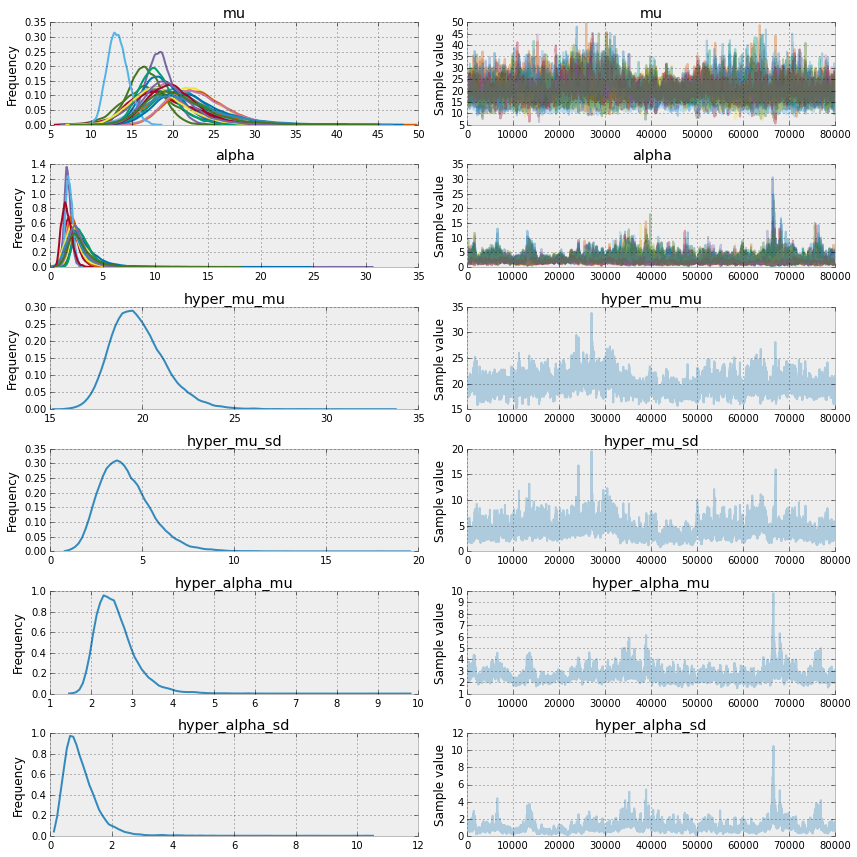

In [9]:
_ = pm.traceplot(hierarchical_trace[120000:], 
                 varnames=['mu','alpha','hyper_mu_mu',
                           'hyper_mu_sd','hyper_alpha_mu',
                           'hyper_alpha_sd'])

You can see for the estimates of $\mu$ and $\alpha$ that we have multiple plots - one for each conversation i. The difference between the pooled and the partially pooled model is that the parameters of the partially pooled model ($\mu_i$ and $\alpha_i$) have a hyperparameter that is shared across all conversations i. This brings two benefits:
1. Information is shared across conversations, so for conversations that have limited sample size, they "borrow" knowledge from other conversations during estimation to help reduce the variance of the estimate
2. We get an estimate for each conversation and an overall estimate for all conversations

Let's have a quick look at the posterior predictive distribution.

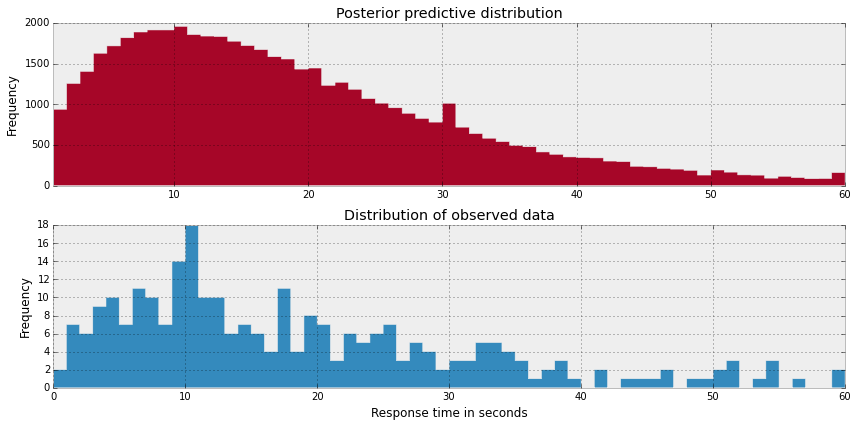

In [10]:
x_lim = 60
y_pred = hierarchical_trace.get_values('y_pred')[::1000].ravel()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

### Shrinkage effect: pooled vs hierarchical model
As discussed, the partially pooled model shared a hyperparameter for both $\mu$ and $\alpha$. By sharing knowledge across conversations, it has the effect of shrinking the estimates closer together - particularly for conversations that have little data.

This shrinkage effect is illustrated in the below plot. You can see how the $\mu$ and $\alpha$ parameters are drawn together by the effect of the hyperparameter.

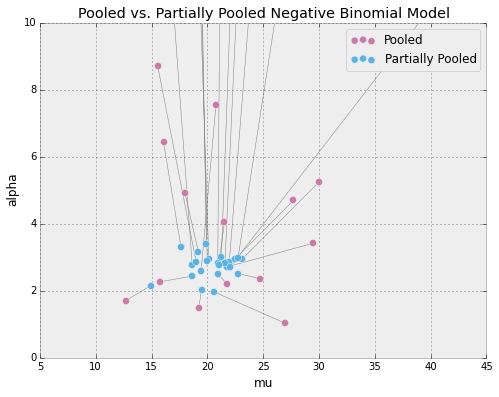

In [11]:
hier_mu = hierarchical_trace['mu'][500:].mean(axis=0)
hier_alpha = hierarchical_trace['alpha'][500:].mean(axis=0)
indv_mu = [indiv_traces[p]['mu'][500:].mean() for p in participants]
indv_alpha = [indiv_traces[p]['alpha'][500:].mean() for p in participants]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='mu', ylabel='alpha', 
                     title='Pooled vs. Partially Pooled Negative Binomial Model', 
                     xlim=(5, 45), ylim=(0, 10))

ax.scatter(indv_mu, indv_alpha, c=colors[5], s=50, label = 'Pooled', zorder=3)
ax.scatter(hier_mu, hier_alpha, c=colors[6], s=50, label = 'Partially Pooled', zorder=4)
for i in range(len(indv_mu)):  
    ax.arrow(indv_mu[i], indv_alpha[i], hier_mu[i] - indv_mu[i], hier_alpha[i] - indv_alpha[i], 
            fc="grey", ec="grey", length_includes_head=True, alpha=.5, head_width=0)

_ = ax.legend()

### Asking questions of the posterior
Let's start to take advantage of one of the best aspects of Bayesian statistics - the posterior distribution. Unlike frequentist techniques, we get a full posterior distribution as opposed to a single point estimate. In essence, we have a basket full of credible parameter values. This enables us to ask some questions in a fairly natural and intuitive manner.

#### What are the chances I'll respond to my friend in less than 10 seconds?
To estimate this probability, we can look at the posterior predctive distribution for Timothy & Andrew's `response_time` and check how many of the samples are < 10 seconds. When I first heard of this technique, I thought I misunderstood because it seemed overly simplistic. 

In [12]:
def participant_y_pred(person):
    """Return posterior predictive for person"""
    ix = np.where(participants == person)[0][0]
    return hierarchical_trace['y_pred'][100000:, ix]

In [13]:
print("Here are some samples from Timothy's posterior predictive distribution: \n %s" % participant_y_pred('Timothy'))

Here are some samples from Timothy's posterior predictive distribution: 
 [24 24 24 ..., 19 19 19]


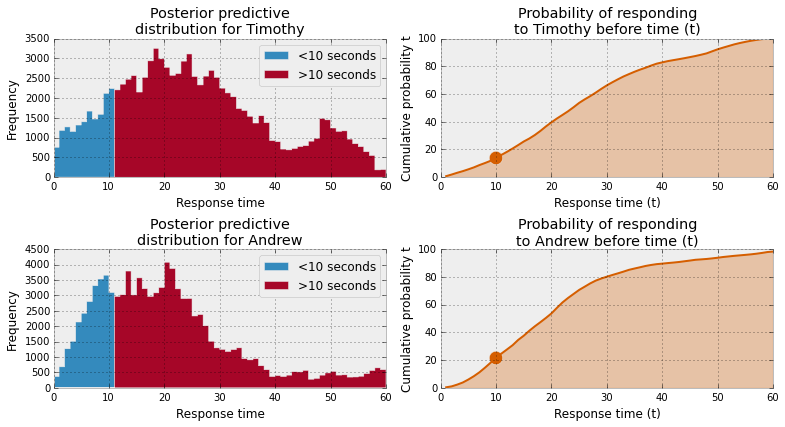

In [14]:
def person_plotA(person_name):
    ix_check = participant_y_pred(person_name) > 10
    _ = plt.hist(participant_y_pred(person_name)[~ix_check], range=[0, x_lim], bins=x_lim, histtype='stepfilled', label='<10 seconds')
    _ = plt.hist(participant_y_pred(person_name)[ix_check], range=[0, x_lim], bins=x_lim, histtype='stepfilled', label='>10 seconds')
    _ = plt.title('Posterior predictive \ndistribution for %s' % person_name)
    _ = plt.xlabel('Response time')
    _ = plt.ylabel('Frequency')
    _ = plt.legend()

def person_plotB(person_name):
    x = np.linspace(1, 60, num=60)
    num_samples = float(len(participant_y_pred(person_name)))
    prob_lt_x = [100*sum(participant_y_pred(person_name) < i)/num_samples for i in x]
    _ = plt.plot(x, prob_lt_x, color=colors[4])
    _ = plt.fill_between(x, prob_lt_x, color=colors[4], alpha=0.3)
    _ = plt.scatter(10, float(100*sum(participant_y_pred(person_name) < 10))/num_samples, s=180, c=colors[4])
    _ = plt.title('Probability of responding \nto %s before time (t)' % person_name)
    _ = plt.xlabel('Response time (t)')
    _ = plt.ylabel('Cumulative probability t')
    _ = plt.ylim(ymin=0, ymax=100)
    _ = plt.xlim(xmin=0, xmax=60)

fig = plt.figure(figsize=(11,6))
_ = fig.add_subplot(221)
person_plotA('Timothy')
_ = fig.add_subplot(222)
person_plotB('Timothy')

_ = fig.add_subplot(223)
person_plotA('Andrew')
_ = fig.add_subplot(224)
person_plotB('Andrew')

plt.tight_layout()

In [15]:
participant_y_pred('Andrew')

array([13, 13, 13, ..., 28, 28, 28])

I find this methodology to be very intuitive and flexible. The plot above left separates the samples from the posterior predictive in terms of being greater than or less than 10 seconds. We can compute the probability by calculating the proportion of samples that are less than 10. The plot on the right simply computes this probability for each response time value from 0 to 60. So, it looks like Timothy & Andrew have a 38% & 8% chance of being responded to in less than 10 seconds, respectively.

#### How do my friends pair off against each other?

In [16]:
def prob_persona_faster(persona, personb):
    return sum(participant_y_pred(persona) < participant_y_pred(personb))/len(participant_y_pred(persona))

print("Probability that Tom is responded to faster than Andrew: {:.2%}".format(prob_persona_faster('Tom', 'Andrew')))

Probability that Tom is responded to faster than Andrew: 33.05%


In [17]:
# Create an empty dataframe
ab_dist_df = pd.DataFrame(index=participants, columns=participants, dtype=np.float)

# populate each cell in dataframe with persona_less_personb()
for a, b in itertools.permutations(participants, 2):
    ab_dist_df.ix[a, b] = prob_persona_faster(a, b)
    
# populate the diagonal
for a in participants:
    ab_dist_df.ix[a, a] = 0.5

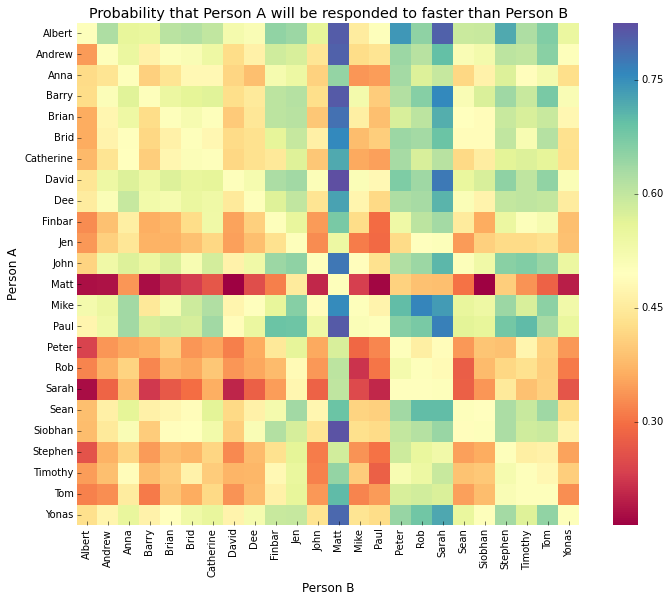

In [18]:
# Plot heatmap
f, ax = plt.subplots(figsize=(12, 9))
cmap = plt.get_cmap("Spectral")
_ = sns.heatmap(ab_dist_df, square=True, cmap=cmap)
_ = plt.title('Probability that Person A will be responded to faster than Person B')
_ = plt.ylabel('Person A')
_ = plt.xlabel('Person B')

#### [>> Go to the Next Section](http://nbviewer.ipython.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%204.%20Bayesian%20regression.ipynb)

### References
1. [The Best Of Both Worlds: Hierarchical Linear Regression in PyMC3](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/) by Thomas Wiecki

In [19]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()